# v01

Here we look at appropriate parameterizations that can be computed quickly.  I'll start with just 3x3 kernels, and and my 3x3 blocks.


There are only 3 unique distances.  So this is 3 parameters for scalars.  2 parameters each for vectors.  And 5 parameters for matrix.  This is 12 parameters.

I will need to make sure this is batched appropriately so it can be computed quickly.

Actually because rotations commute in 2D, there are more degrees of freedom.

3 for scalar

4 each for distances

3 for identity, and 2*4 for outer product.

Total of 22 out of a total 36.  So this is half.

# v02
In v02 I'm just getting rid of some debugging stuf from v01


# v03

In v03 I'm making my network deeper, to be about 250k like resnet

# v04
In v04 I use batch norm. no cutout. use real resnet architecture

# v05

Add rotationally invariant norm and bias.

I added a rotationally invariant nonlinearity too.

I have added the rotationally invariant scale and bias to the bn layer.

I did not make bias rotationally invariant in the conv layer, but I never use this bias currently because it is always followed by batchnomrm.

TODO: a layer that goes from scalar fields to vector fields explicitly.



Note i set normalize to mean 0.5, std 0.5 like medmnist did.

note they use default 100 epochs, and reduce stepsize by 0.1 at .50 and .75.  They use adam and an initial learning rate of 1e-3.


For comparison, they used AUC from SKL.  And the averaged it over each label (i.e. one versus all).

For accuracy, they use skl accuracy_score, not balanced.

They also use batch size of 128.

Also, they use the "best model" on the validation set for testing.  This is the one with the best auc.

Another thing, in the medmnist paper they use 4 scales, with 2 repeats per scale.

I think I will likely need more epochs of training.

# v06

Here I will use four layers with two copies in resnet

In v05 and v06 I fixed my sigmoid rot

# v07


# v08

figured out why it was not rotationally invariant.

Need to do averaging when size is even, and skipping when size is odd.

In [1]:
import torch, torchvision
from torch.utils.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt
%matplotlib widget
# use widget in vscode

plt.set_loglevel('critical')

from sklearn.metrics import roc_auc_score

from importlib import reload
import models

In [2]:
reload(models)
tv = models.ToVector()
x = torch.rand(3,4,8,7)
out = tv(x)
print(out.shape)
m = models.Conv2DRot3x3(12,6)
m(tv(x))
# this will print out the shape of c
#c = models.Conv2DRot(x.shape[1]*3,6,1)
#c(tv(x))

torch.Size([3, 12, 8, 7])


tensor([[[[-1.5053, -1.6714, -1.5220,  ..., -1.5035, -1.5862, -1.4509],
          [-1.6202, -1.8018, -1.9620,  ..., -1.6833, -1.4717, -1.7245],
          [-1.7488, -2.2513, -2.0259,  ..., -1.7701, -1.8518, -1.4579],
          ...,
          [-1.9049, -2.0212, -1.8092,  ..., -1.4277, -1.8445, -1.7607],
          [-1.6923, -1.8483, -1.8355,  ..., -1.9678, -1.7696, -1.5750],
          [-1.4440, -1.7143, -1.5610,  ..., -1.4023, -1.6562, -1.4020]],

         [[-1.0010, -0.7362, -0.6410,  ..., -0.7590, -0.9013, -0.9735],
          [-1.2317, -0.9924, -0.5522,  ..., -1.1194, -1.1228, -0.7073],
          [-1.4427, -0.6052, -0.8124,  ..., -0.5326, -1.1068, -1.0966],
          ...,
          [-1.3480, -1.3333, -0.7513,  ..., -0.9378, -0.8621, -0.7790],
          [-1.2395, -1.0770, -1.1056,  ..., -0.7567, -1.1147, -0.8358],
          [-1.2761, -1.1638, -1.1373,  ..., -0.9743, -0.8769, -0.7740]],

         [[-1.1174, -0.9708, -1.2731,  ..., -1.3751, -0.7448, -1.4577],
          [-0.9640, -1.4471, -

In [3]:
reload(models)
tv = models.ToVector()
x = torch.rand(3,4,8,7)
print(x.shape)
x = tv(x)
print(x.shape)
ksize = 5
m = models.Conv2DRot(x.shape[-3],6,ksize)
m(x)


print(models.count_parameters(m))
print(models.count_parameters(torch.nn.Conv2d(12,6,ksize)))


torch.Size([3, 4, 8, 7])
torch.Size([3, 12, 8, 7])
418
1806


In [4]:
x.ndim

4

In [5]:
count = 0
for p in m.parameters():
    count += p.numel()
count

418

In [6]:
def cutout(I,val=0.5):
    rows = np.random.randint(0,I.shape[-2],(2,))    
    rows.sort()
    cols = np.random.randint(0,I.shape[-1],(2,))    
    cols.sort()
    I[...,rows[0]:rows[1],cols[0]:cols[1]] = val
    return I

In [7]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


In [8]:
my_dataset = torchvision.datasets.CIFAR10(    
    '/home/dtward/data',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(),
                                              torchvision.transforms.RandomCrop(32,padding=4,padding_mode='edge'),
                                              torchvision.transforms.ToTensor(),                                              
                                             # torchvision.transforms.Lambda(cutout)
                                              normalize,
                                             ]
                                            )
)
my_loader = DataLoader(my_dataset, batch_size=64, num_workers=8, shuffle=True)

Files already downloaded and verified


In [9]:
my_dataset_test = torchvision.datasets.CIFAR10(    
    '/home/dtward/data',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
                                              torchvision.transforms.ToTensor(),
                                              normalize,
                                              ])
)
my_loader_test = DataLoader(my_dataset_test, batch_size=64, num_workers=8, shuffle=True)

Files already downloaded and verified


In [10]:
from medmnist import DermaMNIST

In [11]:
normalize = torchvision.transforms.Normalize(mean=0.5,
                                     std=0.5)
# 0.5, 0.5 is used in medmnist code

In [12]:
from medmnist import DermaMNIST as Dataset
#from medmnist import BloodMNIST as Dataset
#from medmnist import PathMNIST as Dataset
#from medmnist import TissueMNIST as Dataset # really big
#from medmnist import BreastMNIST as Dataset # much smaller

In [13]:
my_dataset = Dataset(     
    download=True,
    split='train',    
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),   
                                              normalize
                                             ]
                                            )
)
my_loader = DataLoader(my_dataset, batch_size=128, num_workers=8, shuffle=True)

Using downloaded and verified file: /home/dtward/.medmnist/dermamnist.npz


In [14]:
my_dataset_val = Dataset(        
    split='val',    
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              normalize,
                                             ]
                                            )
)
my_loader_val = DataLoader(my_dataset_val, batch_size=128, num_workers=8, shuffle=True)

In [15]:
my_dataset_test = Dataset(        
    split='test',    
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              normalize,
                                             ]
                                            )
)
my_loader_test = DataLoader(my_dataset_test, batch_size=128, num_workers=8, shuffle=True)
labels = set()
for x,l in my_loader_test:
    labels_i = {li.squeeze().item() for li in l}
    labels = labels.union(labels_i)
n_labels = len(labels)    
print(n_labels)

7


In [16]:

import importlib
import models
importlib.reload(models)

from models import Conv2DRot, ExtractScalar

In [17]:
# now for scalars b we need only 1 number per block, and the others need to be 0
x = torch.randn(1,3,28,28)
z = torch.zeros(1,1,28,28)
x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)
c = torch.nn.Sequential(Conv2DRot(9,9,3,bias=False),ExtractScalar())
for p in c.parameters():
    p.requires_grad = False
# only extract the scalars
out = c(x)

out2 = c(x.rot90(1,dims=(-1,-2))).rot90(-1,dims=(-1,-2))

# okay these are the same to floating point accuracy

print(torch.max(torch.abs(out - out2)))

tensor(3.5763e-07)


tensor(1.3113e-06)


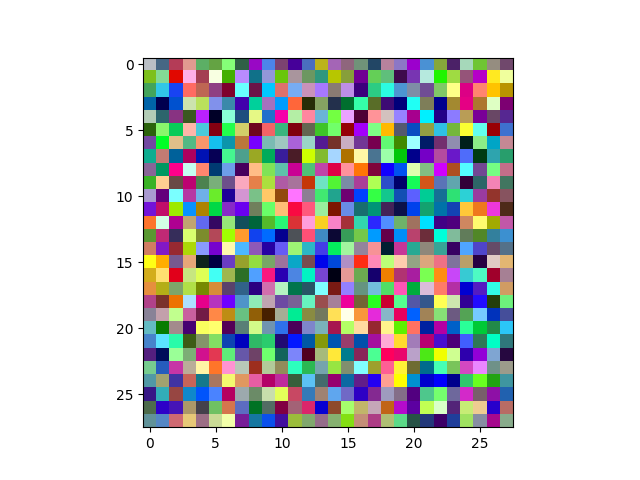

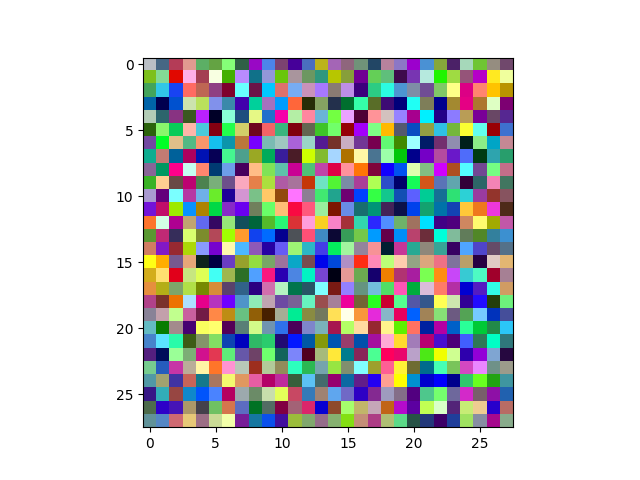

In [18]:
# now for scalars b we need only 1 number per block, and the others need to be 0
x = torch.randn(1,3,28,28)
x = tv(x)
c = torch.nn.Sequential(Conv2DRot(9,18,3,bias=False),Conv2DRot(18,9,3,bias=False),ExtractScalar())
for p in c.parameters():
    p.requires_grad = False
# only extract the scalars
out = c(x)

out2 = c(x.rot90(1,dims=(-1,-2))).rot90(-1,dims=(-1,-2))

# again the same to floating point accuracy (e-7-e-9)
# only when bias is false

fig,ax = plt.subplots()
ax.imshow(out[0].permute(1,2,0)*0.5+0.5)
fig,ax = plt.subplots()
ax.imshow(out2[0].permute(1,2,0)*0.5+0.5)

print(torch.max(torch.abs(out-out2)))

In [19]:
# we need to check that the output is a rotated version of the input
# and we need to check that if our network uses the scalar part, the output is invariant

In [20]:
import importlib
import models
importlib.reload(models)
from models import BatchNormRot

tensor(2.1458e-06)


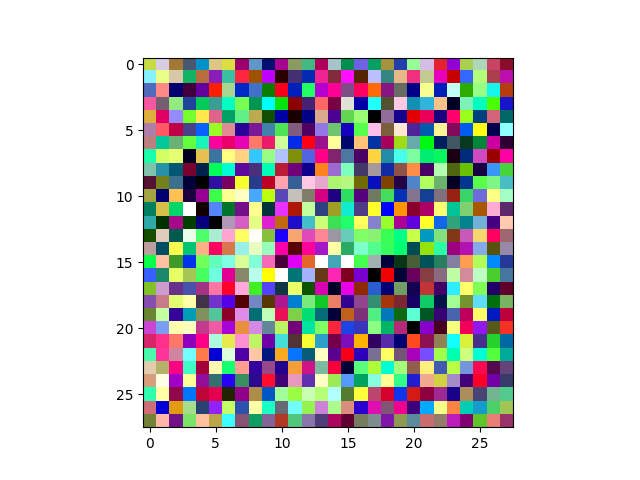

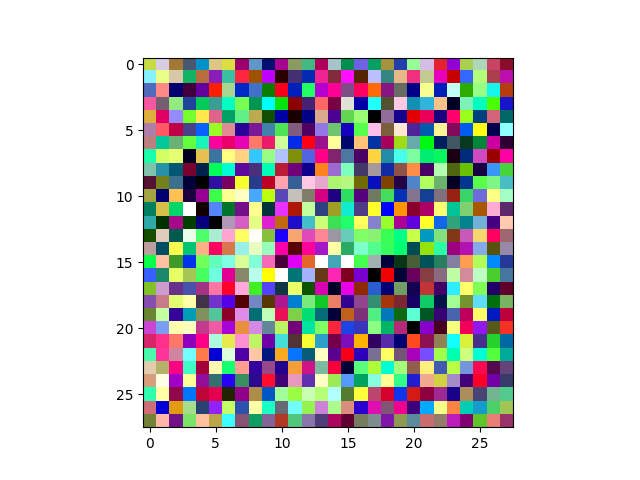

In [21]:
# check that the batchnorm preserves rotational invariance
kernel_size = 3
x = torch.randn(1,3,28,28)
z = torch.zeros(1,1,28,28)
x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)
c = torch.nn.Sequential(Conv2DRot(9,18,kernel_size,bias=False),BatchNormRot(18),Conv2DRot(18,9,kernel_size,bias=False),ExtractScalar())
for p in c.parameters():
    p.requires_grad = False
# only extract the scalars
out = c(x)
out2 = c(x.rot90(1,dims=(-1,-2))).rot90(-1,dims=(-1,-2))

x = torch.randn(1,3,28,28)
z = torch.zeros(1,1,28,28)
x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)


out = c(x)
out2 = c(x.rot90(1,dims=(-1,-2))).rot90(-1,dims=(-1,-2))

x = torch.randn(1,3,28,28)
z = torch.zeros(1,1,28,28)
x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)


out = c(x)
out2 = c(x.rot90(1,dims=(-1,-2))).rot90(-1,dims=(-1,-2))

x = torch.randn(1,3,28,28)
z = torch.zeros(1,1,28,28)
x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)


out = c(x)
out2 = c(x.rot90(1,dims=(-1,-2))).rot90(-1,dims=(-1,-2))

c.eval()
out = c(x)
out2 = c(x.rot90(1,dims=(-1,-2))).rot90(-1,dims=(-1,-2))

# again the same to floating point accuracy (e-7-e-9)
# only when bias is false

fig,ax = plt.subplots()
ax.imshow(out[0].permute(1,2,0)*0.5+0.5)
fig,ax = plt.subplots()
ax.imshow(out2[0].permute(1,2,0)*0.5+0.5)

print(torch.max(torch.abs(out-out2)))

In [22]:
import importlib
import models
importlib.reload(models)
from models import SigmoidRot, ZeroZero

tensor(2.6822e-07)


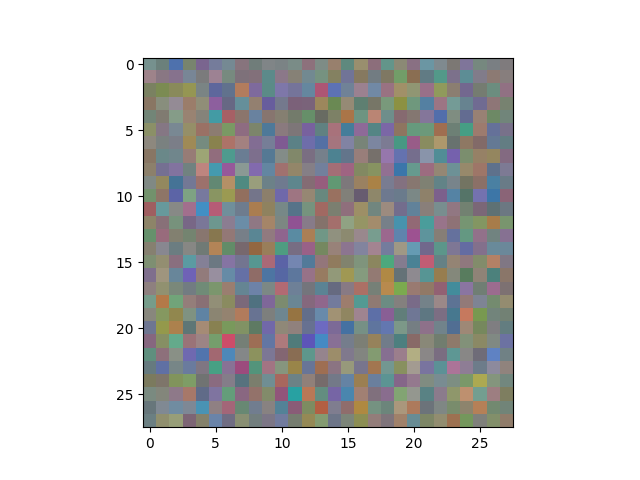

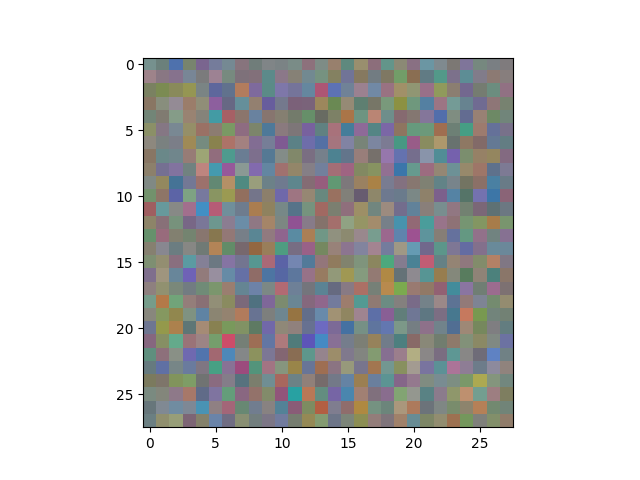

In [23]:
# check rotational invariance
kernel_size = 3
x = torch.randn(1,3,28,28)
z = torch.zeros(1,1,28,28)
x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)

c = torch.nn.Sequential(Conv2DRot(9,18,kernel_size,bias=False),BatchNormRot(18),SigmoidRot(),Conv2DRot(18,9,kernel_size,bias=False),ExtractScalar())
for p in c.parameters():
    p.requires_grad = False

    
    
c.eval()
out = c(x)
out2 = c(x.rot90(1,dims=(-1,-2))).rot90(-1,dims=(-1,-2))

# again the same to floating point accuracy (e-7-e-9)
# only when bias is false

fig,ax = plt.subplots()
ax.imshow(out[0].permute(1,2,0)*0.5+0.5)
fig,ax = plt.subplots()
ax.imshow(out2[0].permute(1,2,0)*0.5+0.5)

print(torch.max(torch.abs(out-out2)))    
    

In [24]:
from IPython import display


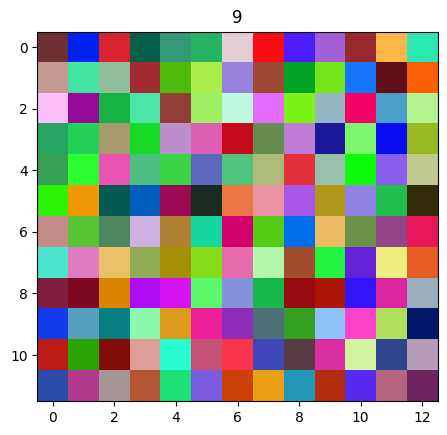

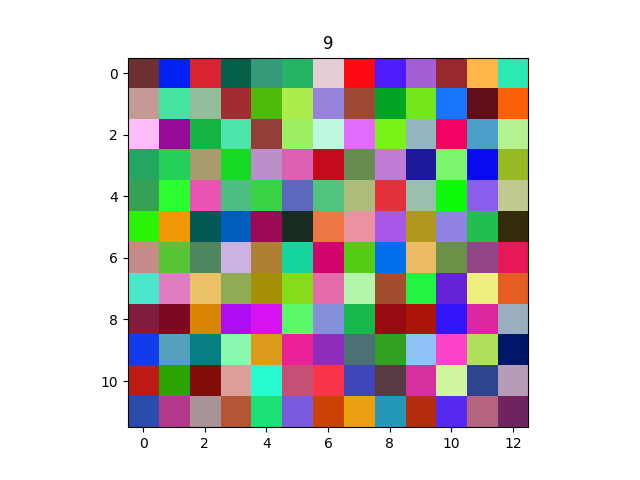

In [25]:
from IPython.display import clear_output, display
%matplotlib widget
fig,ax = plt.subplots()
for it in range(10):
    #clear_output(wait=True)    
    ax.cla()
    ax.imshow(np.random.rand(12,13,3))
    ax.set_title(it)
    #fig.canvas.draw()
    #plt.show()
    clear_output(wait=True)
    display(fig)

In [26]:
# check rotational invariance
kernel_size = 3
c = torch.nn.Sequential(Conv2DRot(9,18,kernel_size,bias=False),BatchNormRot(18),SigmoidRot(),Conv2DRot(18,9,kernel_size, bias=False),ExtractScalar(),torch.nn.AvgPool2d(28),ZeroZero(),torch.nn.Linear(3,10))
for p in c.parameters():
    p.requires_grad = False

c[1].a += torch.randn_like(c[1].a)   
c[1].b += torch.randn_like(c[1].b)   
for i in range(10):
    x = torch.randn(1,3,28,28)
    z = torch.zeros(1,1,28,28)
    x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)

    if i == 9:
        c.eval()
    out = c(x)
    out2 = c(x.rot90(1,dims=(-1,-2)))

    

# again the same to floating point accuracy (e-7-e-9)
# only when bias is false


print(torch.max(torch.abs(out-out2)))    
    

tensor(1.1921e-07)


In [27]:
# check rotational invariance
kernel_size = 3
c = torch.nn.Sequential(Conv2DRot(9,18,kernel_size,bias=False),
                        BatchNormRot(18),
                        SigmoidRot(),
                        Conv2DRot(18,36,kernel_size,bias=False),
                        BatchNormRot(36),
                        SigmoidRot(),
                        Conv2DRot(36,18,kernel_size, bias=False),
                        BatchNormRot(18),
                        SigmoidRot(),
                        Conv2DRot(18,9,kernel_size,bias=False),
                        ExtractScalar(),
                        torch.nn.AvgPool2d(28),
                        ZeroZero(),
                        torch.nn.Linear(3,10))
for p in c.parameters():
    p.requires_grad = False

c[1].a += torch.randn_like(c[1].a)   
c[1].b += torch.randn_like(c[1].b)   
c[4].a += torch.randn_like(c[4].a)   
c[4].b += torch.randn_like(c[4].b)   
c[7].a += torch.randn_like(c[7].a)   
c[7].b += torch.randn_like(c[7].b)   
for i in range(10):
    x = torch.randn(1,3,28,28)
    z = torch.zeros(1,1,28,28)
    x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)

    if i == 9:
        c.eval()
    out = c(x)
    out2 = c(x.rot90(1,dims=(-1,-2)))

    

# again the same to floating point accuracy (e-7-e-9)
# only when bias is false


print(torch.max(torch.abs(out-out2)))    
    

tensor(8.9407e-08)


In [28]:
# check rotational invariance
# this time with stride
# it seems the strided convolutions kind of break the rotational invariance

c = torch.nn.Sequential(Conv2DRot(9,18,kernel_size,bias=False),
                        BatchNormRot(18),
                        SigmoidRot(),
                        Conv2DRot(18,36,kernel_size,stride=2,bias=False),
                        BatchNormRot(36),
                        SigmoidRot(),
                        Conv2DRot(36,18,kernel_size,stride=2,bias=False),
                        BatchNormRot(18),
                        SigmoidRot(),
                        Conv2DRot(18,9,kernel_size,bias=False),
                        ExtractScalar(),
                        torch.nn.AvgPool2d(7),
                        ZeroZero(),
                        torch.nn.Linear(3,10))
for p in c.parameters():
    p.requires_grad = False

c[1].a += torch.randn_like(c[1].a)   
c[1].b += torch.randn_like(c[1].b)   
c[4].a += torch.randn_like(c[4].a)   
c[4].b += torch.randn_like(c[4].b)   
c[7].a += torch.randn_like(c[7].a)   
c[7].b += torch.randn_like(c[7].b)   
for i in range(10):
    x = torch.randn(1,3,28,28)
    z = torch.zeros(1,1,28,28)
    x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)

    if i == 9:
        c.eval()
    out = c(x)
    out2 = c(x.rot90(1,dims=(-1,-2)))

    

# again the same to floating point accuracy (e-7-e-9)
# only when bias is false


print(torch.max(torch.abs(out-out2)))    
    

tensor(0.0322)


In [29]:
importlib.reload(models)
from models import Down2Rot

In [30]:
# check rotational invariance
# this time with stride
# it seems the strided convolutions kind of break the rotational invariance
kernel_size = 3
c = torch.nn.Sequential(Conv2DRot(9,18,kernel_size,bias=False),
                        BatchNormRot(18),
                        SigmoidRot(),
                        Conv2DRot(18,36,kernel_size,bias=False),
                        Down2Rot(),
                        BatchNormRot(36),
                        SigmoidRot(),
                        Conv2DRot(36,18,kernel_size,bias=False),
                        Down2Rot(),
                        BatchNormRot(18),
                        SigmoidRot(),
                        Conv2DRot(18,9,kernel_size,bias=False),
                        ExtractScalar(),
                        torch.nn.AvgPool2d(7),
                        ZeroZero(),
                        torch.nn.Linear(3,10))
for p in c.parameters():
    p.requires_grad = False

c[1].a += torch.randn_like(c[1].a)   
c[1].b += torch.randn_like(c[1].b)   
c[5].a += torch.randn_like(c[5].a)   
c[5].b += torch.randn_like(c[5].b)   
c[9].a += torch.randn_like(c[9].a)   
c[9].b += torch.randn_like(c[9].b)   
for i in range(10):
    x = torch.randn(1,3,28,28)
    z = torch.zeros(1,1,28,28)
    x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)

    if i == 9:
        c.eval()
    out = c(x)
    out2 = c(x.rot90(1,dims=(-1,-2)))

    

# again the same to floating point accuracy (e-7-e-9)
# only when bias is false


print(torch.max(torch.abs(out-out2)))    
    

tensor(5.9605e-08)


In [31]:
# check rotational invariance
# this time with stride
# it seems the strided convolutions kind of break the rotational invariance

c = torch.nn.Sequential(Conv2DRot(9,18,kernel_size,bias=False),
                        BatchNormRot(18),
                        SigmoidRot(),
                        Conv2DRot(18,36,kernel_size,bias=False),
                        torch.nn.AvgPool2d(2),
                        BatchNormRot(36),
                        SigmoidRot(),
                        Conv2DRot(36,18,kernel_size,bias=False),
                        Down2Rot(),
                        BatchNormRot(18),
                        SigmoidRot(),
                        Conv2DRot(18,9,kernel_size,bias=False),
                        ExtractScalar(),
                        torch.nn.AvgPool2d(7),
                        ZeroZero(),
                        torch.nn.Linear(3,10))
for p in c.parameters():
    p.requires_grad = False

c[1].a += torch.randn_like(c[1].a)   
c[1].b += torch.randn_like(c[1].b)   
c[5].a += torch.randn_like(c[5].a)   
c[5].b += torch.randn_like(c[5].b)   
c[9].a += torch.randn_like(c[9].a)   
c[9].b += torch.randn_like(c[9].b)   
for i in range(10):
    x = torch.randn(1,3,28,28)
    z = torch.zeros(1,1,28,28)
    x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)

    if i == 9:
        c.eval()
    out = c(x)
    out2 = c(x.rot90(1,dims=(-1,-2)))

    

# again the same to floating point accuracy (e-7-e-9)
# only when bias is false


print(torch.max(torch.abs(out-out2)))    
    

tensor(1.4901e-08)


In [32]:
# note it seems the downsampling breaks the rotational invariance
# i.e. if the last pixel gets left off
# the last pixel will depend on the rotation
# so if the size is even, we will want to average
# if the size is odd, we will want to skip

In [33]:
# what do I want to do?
# check the magnitude
# if it is less than k multiply the vector by 0
# if it is greater than k, multiply by 1?
# no that's not quite right
# that's kind o like relu
# if it's less than 0 multiply by0
# if it's greater than 0, multiply by 1
# the differences is the relu leads to a continuous function
# but this doesn't, or does it?

In [34]:
# test
np.mean( np.sum(np.random.randn(10000,2)**2,-1)  > 1.5)

0.4727

In [35]:
np.mean( np.sum(np.random.randn(10000,2)**2,-1)**0.5  > 1.1)

0.5557

In [36]:
np.sqrt(2)

1.4142135623730951

A 1x1 convolution is just multiply by a matrix
J(x) = AI(x)

If I is a scalar then it's trivially true

If I is a vector then
A RI(R^{-1}x)

A has to commute with R, that means it needs to be proportional to identity, or in 2D be any rotation.

In [37]:
device = 'cuda:0'

In [38]:

from models import train_and_eval

11033148


KeyboardInterrupt: 

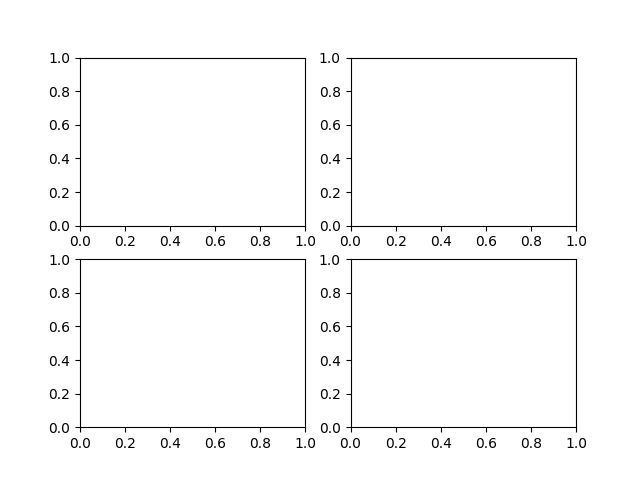

In [39]:
# 18 layers was used in the medmnist
# with 126 it does best, but its a bit more parameters than the resnet below
# I could try 123
reload(models)
net = models.RotNet18(n0=123,n1=n_labels)
# 126 gives 11 million parameters, the resnet below is only 10 million, so we could do a bit less
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device,)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])

In [ ]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# 18 layers was used in the medmnist
# with 126 it does best, but its a bit more parameters than the resnet below
# I could try 123
# or let's try 32 scalars and 32 vectors
# this is way less parameters
reload(models)
net = models.RotNet18(n0=66,n1=n_labels)
# 126 gives 11 million parameters, the resnet below is only 10 million, so we could do a bit less
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device,)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])

In [ ]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
reload(models)
net = models.RotNet18(n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])

In [ ]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()

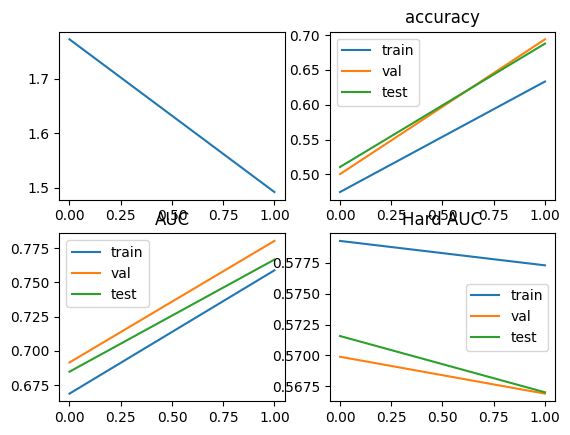

torch.Size([128, 3, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 9, 28, 28])
torch.Size([128, 15, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 9, 28, 28])
torch.Size([128, 15, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 9, 28, 28])
torch.Size([128, 15, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 9, 28, 28])
torch.Size([128, 15, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 9, 28, 28])
torch.Size([128, 15, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 9, 28, 28])
torch.Size([128, 15, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 9, 28, 28])
torch.Size([128, 15, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 9, 28, 28])
torch.Size([128, 15, 28, 28])
torch.Size([128, 3, 28, 28])
torch.Size([128, 3, 28, 28])
torch.

KeyboardInterrupt: 

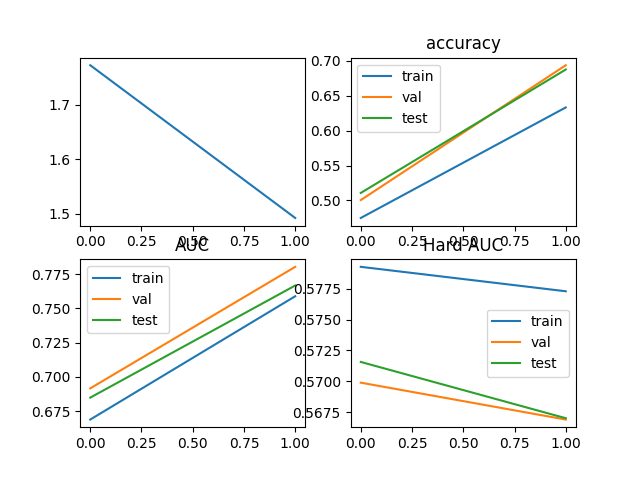

In [50]:
# 20 layers is from cifar
reload(models)
net = models.RotNet20(n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device,)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])

In [ ]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# 20 layers is from cifar, but lets try 5x5
reload(models)
net = models.RotNet20(n1=n_labels,kernel_size=5)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device,)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])

In [ ]:
# 20 layers is from cifar
# extra channels so it matches parameters
# below is about 400K
net = models.RotNet20(n0=36,n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device,)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])

In [ ]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
net = models.ResNet18(n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device,)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])

In [ ]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# this is the resnet from the resnet paper for cifar10
net = models.ResNet20(n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device,)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])

In [ ]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()